In [1]:
from parse_JFL import *
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, series, simplify

In [2]:
def z(r,R,Q):
    return (1/R)*r**2/(1+np.sqrt(1-(1+Q**2)*(1/R)**2*r**2))

def odd_asphere(r, R, Q, alpha):
    if R != 0:
        # Calculate the denominator for the sqrt operation
        sqrt_denom = 1 - (1 + Q) * (1/R)**2 * r**2
        # Handle cases where the sqrt_denom is negative
        sqrt_denom = np.where(sqrt_denom < 0, 0, sqrt_denom)
        # Now safely compute the first part
        first_part = (1/R) * r**2 / (1 + np.sqrt(sqrt_denom))
    else:
        first_part = np.zeros_like(r)  # If R is 0, set the first part to zero for all r

    # Calculate the polynomial part
    powers = np.arange(1, len(alpha) + 1)  # Starts at 1, as powers start from 1
    polynomial_part = np.sum(alpha * np.power(r[:, np.newaxis], powers), axis=1)

    return first_part + polynomial_part

def axiconOddAsphereParams(axiconDiameter, axiconHeight, axiconRadius, maxOrder=16):
    Cz, Cy, r, z = symbols('Cz Cy r z')
    equationsCzCy = [
        Eq(Cz**2 + Cy**2, axiconRadius**2),
        Eq((Cz - axiconHeight)**2 + (Cy - axiconDiameter / 2)**2, axiconRadius**2)
    ]
    
    # Solve the equations for Cz and Cy
    resultCzCy = solve(equationsCzCy, (Cz, Cy))
    
    # Filter out solutions where Cz <= 0
    valid_resultCzCy = [sol for sol in resultCzCy if sol[0] > 0][0]
    Cz_value, Cy_value = valid_resultCzCy
    
    # Find the series expansion of z(r)
    z_exp = solve(Eq((z - Cz)**2 + (r - Cy)**2, Cz**2 + Cy**2), z)[0]
    z_exp_sub = z_exp.subs({Cz: Cz_value, Cy: Cy_value})
    
    # Series expansion and simplification
    z_series = series(z_exp_sub, r, 0, maxOrder + 1)
    z_series_simplified = simplify(z_series)
    
    # Extract the coefficients
    coeff = [z_series_simplified.coeff(r, i) for i in range(1, maxOrder + 1)]
    
    return np.array(coeff)

In [18]:
microlens_semi_diameter = 1.1/2
microlens_R=107.4545
microlens_Q=0
base_lens_R=236.4 
base_lens_semi_diameter = 5.15
base_lens_Q=0
whole_lens_semi_diameter=7

base_lens_back_R=107.4545
base_lens_back_Q=0
base_lens_back_semi_diameter=5.12

center_thickness=0.2
axicon_hight_in_um=2.5

In [5]:
base_file_path = 'MCOK001OS.JFL'  
segments = parse_jfl_file(base_file_path)

In [6]:
microlens_x=find_x_in_range(segments,'F', 
    0, microlens_semi_diameter)
base_lens_x=find_x_in_range(segments,'F', 
    microlens_semi_diameter, base_lens_semi_diameter)
base_lens_back_x=find_x_in_range(segments,'B', 
    0, base_lens_back_semi_diameter)

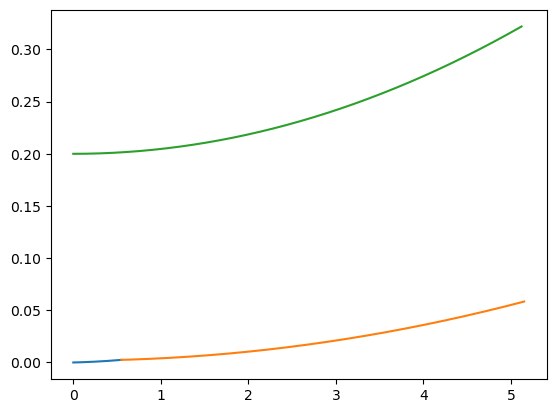

In [7]:
microlens_sag=odd_asphere(microlens_x,0,0,axiconOddAsphereParams(microlens_semi_diameter*2, 2.5/1000, microlens_R,16))
base_lens_sag_tmp=z(base_lens_x,base_lens_R,base_lens_Q)
delta_sag=microlens_sag[0]-base_lens_sag_tmp[-1]
base_lens_sag=base_lens_sag_tmp+delta_sag
base_lens_back_sag=z(base_lens_back_x,base_lens_back_R,base_lens_back_Q)+center_thickness
plt.plot(microlens_x,microlens_sag)
plt.plot(base_lens_x,base_lens_sag)
plt.plot(base_lens_back_x,base_lens_back_sag)
plt.show()

Segment F replaced successfully.
Segment F replaced successfully.
Segment F translated successfully.
Segment B replaced successfully.
Segment B translated successfully.
Segment E translated successfully.


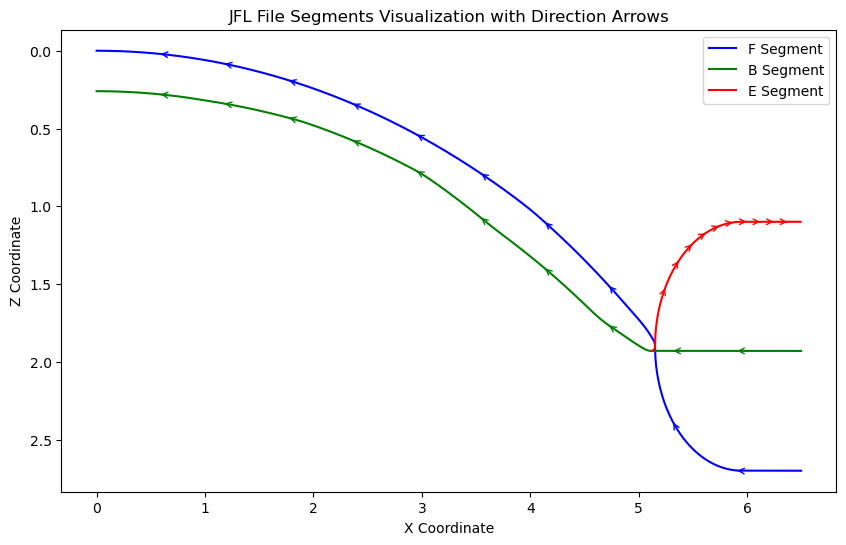

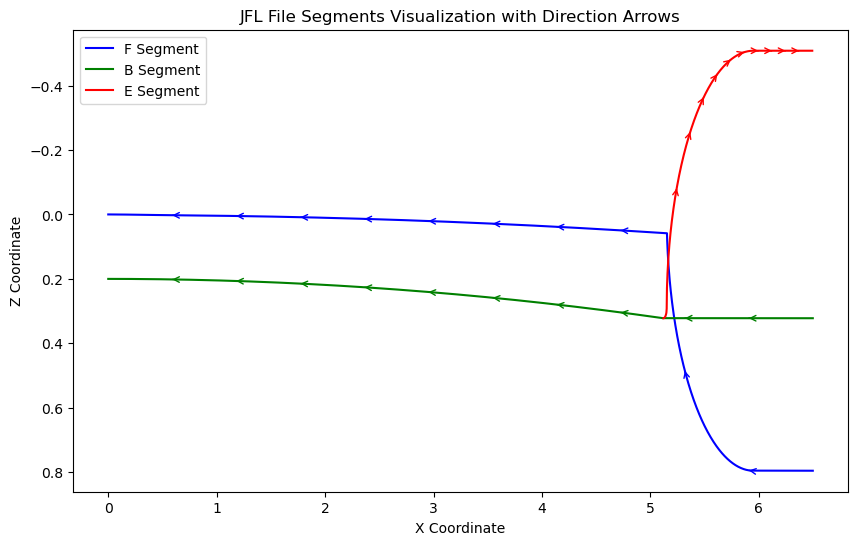

<module 'matplotlib.pyplot' from 'c:\\Users\\goldengrape\\miniconda3\\envs\\zemax\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
segments1=replace_segment(segments,'F',
            0,
            microlens_semi_diameter,
            microlens_sag)
segments2=replace_segment(segments1,'F',
            microlens_semi_diameter,
            base_lens_semi_diameter,
            base_lens_sag)
segments3=translate_segment(segments2,'F',
            base_lens_semi_diameter,whole_lens_semi_diameter,
            base_lens_sag[0])
segments4=replace_segment(segments3,'B',
            0,
            base_lens_back_semi_diameter,
            base_lens_back_sag)
segments5=translate_segment(segments4,'B',
            base_lens_back_semi_diameter,whole_lens_semi_diameter,
            base_lens_back_sag[0])
segments6=translate_segment(segments5,'E',
            base_lens_back_semi_diameter,whole_lens_semi_diameter,
            base_lens_back_sag[0],head='min')
plot_jfl_segments_with_arrows(segments)
plot_jfl_segments_with_arrows(segments6)

In [9]:
save_jfl_file(segments6,'new.JFL')

File saved successfully to new.JFL


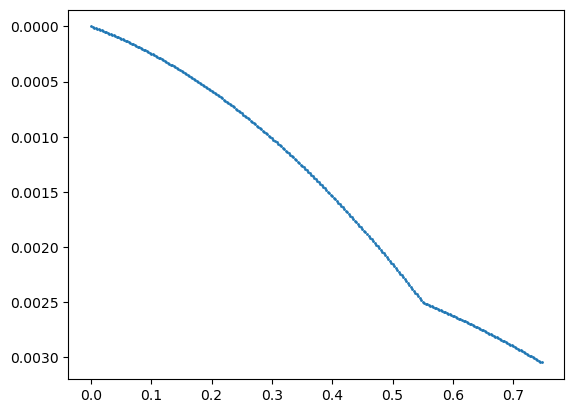

In [17]:
plt.scatter(segments6['F'][-300:,0],segments6['F'][-300:,1], s=1)
plt.gca().invert_yaxis()
plt.show()
